In [1]:
# See below on how to add your custom method into
# the CASP15 EMA evaluation
import json
import os
import random

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

In [2]:
# DataFrame is already filtered and only contains data
# for structures that are actually evaluated in overall
# EMA analysis
df = pd.read_csv("global_df.csv")

with open("../ema_targets.json", 'r') as fh:
    target_data = json.load(fh)
    
# target_data is a dict with key: target, value: list of target_files
# we're always gonna use the first target file
# The only targets where this will have real implications is
# H1171 and H1172 where we have several slightly different versions
target_data = {k: v[0] for k,v in target_data.items()}

# load group mapping
with open("../group_mappings.json", 'r') as fh:
    group_mappings = json.load(fh)

# manually add entry for baseline
group_mappings["AC"] = "AC"

# some color definitions required later on
cred = (128.0/255,0.0,0.0)
cblue = (102.0/255,153.0/255,204.0/255)

In [3]:
# Hardcoded group ids - they're derived in the overall
# EMA analysis notebook
SCORE_eval_groups = ['AC', '494', '398', '298', '283', '275', '266', '121', '120', '086', '083', '041', '002', '248', '158', '089', '169', '098', '468', '426', '168', '282', '245']
QSCORE_eval_groups = ['AC', '494', '398', '275', '266', '121', '086', '083', '041', '002', '248', '158', '468', '426', '168', '245', '089', '101']

In [4]:
# ADD YOUR OWN GROUP TO SCORE ANALYSIS
# 
# The equivalent operations can be done to
# add a custom group to QSCORE evaluation
##########################################

my_id = '4242'
my_group_name = 'cheese'

# add to the groups that are evaluated
SCORE_eval_groups.append(my_id)
QSCORE_eval_groups.append(my_id)
# and link my_id with my_group_name
group_mappings[my_id] = my_group_name

# add predictions to dataframe
# either add the scores interactively as shown here
# or directly edit the csv file to add column with name
# my_id + "_SCORE"
score_col_name = my_id + "_SCORE"
score_col = list()
for mdl in df["mdl"]:
    # derive highly accurate prediction for mdl
    score = random.random()
    score_col.append(score)
df[score_col_name] = score_col

# same for QSCORE
qscore_col_name = my_id + "_QSCORE"
qscore_col = list()
for mdl in df["mdl"]:
    # derive highly accurate prediction for mdl
    qscore = random.random()
    qscore_col.append(qscore)
df[qscore_col_name] = qscore_col

# DONE
######


In [5]:
# evaluation metrics
def adaptive_rocauc(df, target, pred):
    """ Returns ROC AUC with an adaptive class threshold
    
    Adaptive in a sense that the top quantile according target
    is considered positive.
    """
    thresh = df[target].quantile(0.75)
    sub_df = df[(df[target].isnull() == False) & (df[pred].isnull() == False)]
    target_classes = [int(x>thresh) for x in sub_df[target]]
    return max(0.5, roc_auc_score(target_classes, sub_df[pred]))

def pearson_corr(df, target, pred):
    """ Returns pearson correlation
    """
    if df[pred].nunique() == 1:
        return 0.0 # group 168 thinks its funny to return the same value for all models in a target
    return df[target].corr(df[pred], method="pearson")

def spearman_corr(df, target, pred):
    """ Returns spearman correlation
    """
    if df[pred].nunique() == 1:
        return 0.0 # group 168...
    return df[target].corr(df[pred], method="spearman")

def diff_to_best(df, target, pred):
    best_score = df[target].max()
    selected_score = df[target][df[pred].idxmax()]
    return best_score - selected_score

In [6]:
def per_target_eval(df, target, eval_groups, score_or_qscore,
                    target_data, filter_target, filter_target_thresh,
                    metrics={"pearson_r": pearson_corr,
                             "spearman_r": spearman_corr,
                             "roc_auc": adaptive_rocauc,
                             "loss": diff_to_best}):
    """ Returns DataFrame with one row per target
    
    For each target, each group is evaluated against specified metrics
    (default: pearson_r, spearman_r, roc_auc, loss)
    
    So let's say you have one target (x) and one group (y), you'll get the 
    following columns: x, y_pearson_r, y_spearman_r, y_roc_auc, y_loss
    
    :param df: The overall per-model DataFrame
    :type df: :class:`DataFrame`
    :param target: The target value, e.g. tm_score, gdtts, qs_best, dockq_wave
    :type target: :class:`str`
    :param eval_groups: List of groups that are evaluated (y in example above)
    :type eval_groups: :class:`list` of :class:`str`
    :param score_or_qscore: 'SCORE' or 'QSCORE'
    :type score_or_qscore: :class:`str`
    :param target_data: Dictionary used in overall evaluation, i.e. trg name as key
                        and respective target file as value
    :type target_data: :class:`dict`
    :param filter_target: Target value used for filtering, i.e. target will be skipped if 
                          no model has the respective value above *filter_target_thresh*
                          (e.g. tm_score, qs_best, etc.)
    :type filter_target: :class:`str`
    :param filter_target_thresh: Threshold for specified *filter_target*
    :type filter_target_tresh: :class:`float`
    :param metrics: Evaluation metrics... shouldn't be changed...
    :type metrics: :class:`dict`
    """
    data = {"trg": list()}
    for g in eval_groups:
        for m in metrics.keys():
            data[g + "_" + m] = list()
    for trg, trg_file in target_data.items():
        sub_df = df[df["trg"] == trg_file]
        # skip targets that have been filtered out completely in preprocessing (happens for T1192o)
        if sub_df.shape[0] == 0:
            print(f"no data for {trg}... skip...")
            continue
        # per-target evaluation only assesses targets which fulfill very crude
        # quality filter, e.g. max TMscore of any of the models > 0.6
        if sub_df[filter_target].max() < filter_target_thresh:
            print("skip trg", trg)
            continue
        data["trg"].append(trg)
        for g in eval_groups:
            n_exp = sub_df.shape[0]
            n_pred = sub_df[sub_df[g+f"_{score_or_qscore}"].isnull()==False].shape[0]
            if float(n_pred)/n_exp < 0.8:
                # not enough predictions for g
                for m in metrics.keys():
                    data[g + "_" + m].append(None)
            else:
                for m,f in metrics.items():
                    data[g + "_" + m].append(f(sub_df, target, f"{g}_{score_or_qscore}"))
    return pd.DataFrame.from_dict(data)

def per_group_eval(per_target_df, eval_groups,
                   metrics=["pearson_r", "spearman_r", "roc_auc", "loss"]):
    """ Takes per_target evaluation with respect to one target value (e.g. tm_score)
    and returns DataFrame with per group averages
    
    So lets say you have one group x, you'll get a DataFrame with the following columns:
    x, pearson_r, spearman_r, roc_auc, loss where the evaluation metrics represent the
    per-target averages.
    
    :param per_target_df: Return value of :func:`per_target_eval`
    :type per_target_df: :class:`DataFrame`
    :param eval_groups: List of groups that are evaluated, must be consistent with what
                        you give :func:`per_target_eval`
    :type eval_groups: :class:`list` of :class:`str`
    :param metrics: Metrics you evaluate with, must be consistent with what you give
                    :func:`per_target_eval`
    :type metrics: :class:`list` of :class:`str`
    """
    data = {"group": list()}
    for m in metrics:
        data[m] = list()
    for g in eval_groups:
        data["group"].append(g)
        for m in metrics:
            data[m].append(per_target_df[f"{g}_{m}"].mean())
    return pd.DataFrame.from_dict(data)

In [7]:
# prepare SCORE data
tm_per_target_df = per_target_eval(df, "tm_score", SCORE_eval_groups, "SCORE", target_data, "tm_score", 0.6)
tm_per_group_df = per_group_eval(tm_per_target_df, SCORE_eval_groups)
gdtts_per_target_df = per_target_eval(df, "gdtts", SCORE_eval_groups, "SCORE", target_data, "tm_score", 0.6)
gdtts_per_group_df = per_group_eval(gdtts_per_target_df, SCORE_eval_groups)

from scipy.stats import zscore
z_tm_per_group_df = tm_per_group_df.copy()
numeric_cols = z_tm_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_tm_per_group_df[nc] = zscore(z_tm_per_group_df[nc])

z_gdtts_per_group_df = gdtts_per_group_df.copy()
numeric_cols = z_gdtts_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_gdtts_per_group_df[nc] = zscore(z_gdtts_per_group_df[nc])

# reverse Z-scores of loss columns (low is good)
z_tm_per_group_df["loss"] = (-1.0) * z_tm_per_group_df["loss"]
z_gdtts_per_group_df["loss"] = (-1.0) * z_gdtts_per_group_df["loss"]

# don't punish for abysmal performance => set negative z-scores to 0.0
num = z_tm_per_group_df._get_numeric_data()
num[num < 0] = 0
num = z_gdtts_per_group_df._get_numeric_data()
num[num < 0] = 0

skip trg T1176o
no data for T1192o... skip...
skip trg T1176o
no data for T1192o... skip...


In [8]:
# prepare QSCORE data
qs_per_target_df = per_target_eval(df, "qs_best", QSCORE_eval_groups, "QSCORE", target_data, "qs_best", 0.6)
qs_per_group_df = per_group_eval(qs_per_target_df, QSCORE_eval_groups)
dockq_per_target_df = per_target_eval(df, "dockq_wave", QSCORE_eval_groups, "QSCORE", target_data, "qs_best", 0.6)
dockq_per_group_df = per_group_eval(dockq_per_target_df, QSCORE_eval_groups)

# compute Z-scores
z_qs_per_group_df = qs_per_group_df.copy()
numeric_cols = z_qs_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_qs_per_group_df[nc] = zscore(z_qs_per_group_df[nc])

z_dockq_per_group_df = dockq_per_group_df.copy()
numeric_cols = z_dockq_per_group_df.select_dtypes(include=[np.number]).columns
for nc in numeric_cols:
    z_dockq_per_group_df[nc] = zscore(z_dockq_per_group_df[nc])

# reverse Z-scores of loss columns (low is good)
z_qs_per_group_df["loss"] = (-1.0) * z_qs_per_group_df["loss"]
z_dockq_per_group_df["loss"] = (-1.0) * z_dockq_per_group_df["loss"]

# don't punish for abysmal performance => set negative z-scores to 0.0
num = z_qs_per_group_df._get_numeric_data()
num[num < 0] = 0
num = z_dockq_per_group_df._get_numeric_data()
num[num < 0] = 0

skip trg T1176o
no data for T1192o... skip...
skip trg T1176o
no data for T1192o... skip...


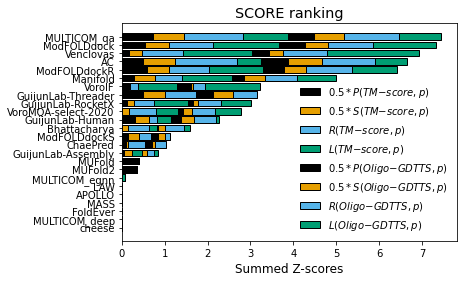

In [13]:
# do SCORE plot

# apply the magic formula 
final_score_tm = 0.5*z_tm_per_group_df["pearson_r"] + 0.5*z_tm_per_group_df["spearman_r"] + z_tm_per_group_df["roc_auc"] + z_tm_per_group_df["loss"]
final_score_gdtts = 0.5*z_gdtts_per_group_df["pearson_r"] + 0.5*z_gdtts_per_group_df["spearman_r"] + z_gdtts_per_group_df["roc_auc"] + z_gdtts_per_group_df["loss"]
final_score = np.add(final_score_tm, final_score_gdtts)

# sort tables by final score
z_tm_per_group_df["final_score"] = final_score
z_gdtts_per_group_df["final_score"] = final_score
z_tm_per_group_df.sort_values("final_score", inplace=True)
z_gdtts_per_group_df.sort_values("final_score", inplace=True)


# stolen from http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt.clf()
y = list(range(z_tm_per_group_df.shape[0]))

left = np.array([0] * len(y))
plt.barh(y, 0.5*z_tm_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(TM\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_tm_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_tm_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(TM\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_tm_per_group_df["spearman_r"])
plt.barh(y, z_tm_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(TM\mathrm{-}score,p)$")

left = np.add(left, z_tm_per_group_df["roc_auc"])
plt.barh(y, z_tm_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(TM\mathrm{-}score,p)$")

left = np.add(left, z_tm_per_group_df["loss"])
plt.barh(y, 0.5*z_gdtts_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(Oligo\mathrm{-}GDTTS,p)$")

left = np.add(left, 0.5*z_gdtts_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_gdtts_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(Oligo\mathrm{-}GDTTS,p)$")

left = np.add(left, 0.5*z_gdtts_per_group_df["spearman_r"])
plt.barh(y, z_gdtts_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(Oligo\mathrm{-}GDTTS,p)$")

left = np.add(left, z_gdtts_per_group_df["roc_auc"])
plt.barh(y, z_gdtts_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(Oligo\mathrm{-}GDTTS,p)$")


plt.title("SCORE ranking", fontsize="x-large")
plt.yticks(y, [group_mappings[x] for x in z_tm_per_group_df["group"]])
plt.xlabel("$RS_{SCORE}(p)$", fontsize = "large")
plt.legend(frameon=False)

Text(0.5, 0, '$N$')

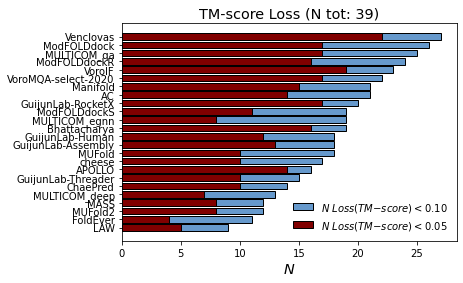

In [14]:
# do SCORE loss plot

thresh = 0.1
sub_df = tm_per_target_df[[col for col in tm_per_target_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.10$")
plt.yticks(y, labels)

# slab bars with even higher quality on top

thresh = 0.05
sub_df = tm_per_target_df[[col for col in tm_per_target_df.columns if "loss" in col]]
highq_loss_count = sub_df[sub_df < thresh].count()
highq_labels = [item for item in highq_loss_count.index.array]
highq_labels = [group_mappings[item.split('_')[0]] for item in highq_labels]
highq_loss_dict = {label:loss for label, loss in zip(highq_labels, highq_loss_count.array)}

highq_values = [highq_loss_dict[l] for l in labels]
plt.barh(y, highq_values, color=cred, linewidth=1.0, edgecolor='k', label="$N\ Loss(TM\mathrm{-}score)<0.05$")
plt.legend(frameon=False)
plt.title(f"TM-score Loss (N tot: {tm_per_target_df.shape[0]})", fontsize="x-large")
plt.xlabel("$N$", fontsize="x-large")

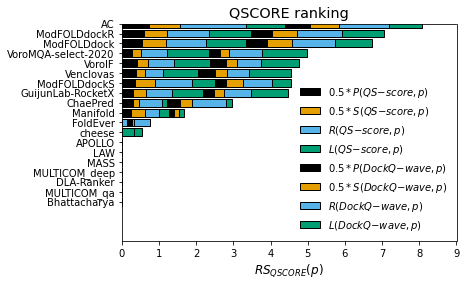

In [16]:
# do QSCORE plot

# apply the magic formula 
final_score_qs = 0.5*z_qs_per_group_df["pearson_r"] + 0.5*z_qs_per_group_df["spearman_r"] + z_qs_per_group_df["roc_auc"] + z_qs_per_group_df["loss"]
final_score_dockq = 0.5*z_dockq_per_group_df["pearson_r"] + 0.5*z_dockq_per_group_df["spearman_r"] + z_dockq_per_group_df["roc_auc"] + z_dockq_per_group_df["loss"]
final_score = np.add(final_score_qs, final_score_dockq)

# sort tables by final score
z_qs_per_group_df["final_score"] = final_score
z_dockq_per_group_df["final_score"] = final_score
z_qs_per_group_df.sort_values("final_score", inplace=True)
z_dockq_per_group_df.sort_values("final_score", inplace=True)


# stolen from http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plt.clf()
y = list(range(z_qs_per_group_df.shape[0]))

left = np.array([0] * len(y))
plt.barh(y, 0.5*z_qs_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(QS\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_qs_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_qs_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(QS\mathrm{-}score,p)$")

left = np.add(left, 0.5*z_qs_per_group_df["spearman_r"])
plt.barh(y, z_qs_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(QS\mathrm{-}score,p)$")

left = np.add(left, z_qs_per_group_df["roc_auc"])
plt.barh(y, z_qs_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(QS\mathrm{-}score,p)$")

left = np.add(left, z_qs_per_group_df["loss"])
plt.barh(y, 0.5*z_dockq_per_group_df["pearson_r"], left=left, color=colors[0], linewidth=1.0, edgecolor='k', label="$0.5*P(DockQ\mathrm{-}wave,p)$")

left = np.add(left, 0.5*z_dockq_per_group_df["pearson_r"])
plt.barh(y, 0.5*z_dockq_per_group_df["spearman_r"], left=left, color=colors[1], linewidth=1.0, edgecolor='k', label="$0.5*S(DockQ\mathrm{-}wave,p)$")

left = np.add(left, 0.5*z_dockq_per_group_df["spearman_r"])
plt.barh(y, z_dockq_per_group_df["roc_auc"], left=left, color=colors[2], linewidth=1.0, edgecolor='k', label="$R(DockQ\mathrm{-}wave,p)$")

left = np.add(left, z_dockq_per_group_df["roc_auc"])
plt.barh(y, z_dockq_per_group_df["loss"], left=left, color=colors[3], linewidth=1.0, edgecolor='k', label="$L(DockQ\mathrm{-}wave,p)$")


plt.title("QSCORE ranking", fontsize="x-large")
plt.yticks(y, [group_mappings[x] for x in z_qs_per_group_df["group"]])
plt.xlabel("$RS_{QSCORE}(p)$", fontsize = "large")
plt.xlim((0,9))
plt.ylim((-4, 18))
plt.legend(frameon=False)

Text(0.5, 0, '$N$')

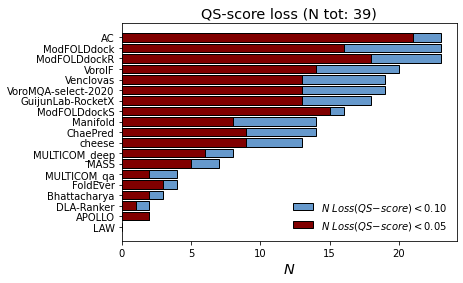

In [15]:
# do QSCORE loss plot

thresh = 0.1
sub_df = qs_per_target_df[[col for col in qs_per_target_df.columns if "loss" in col]]
loss_count = sub_df[sub_df < thresh].count()
loss_count.sort_values(inplace=True)

y = list(range(loss_count.size))
labels = [item for item in loss_count.index.array]
labels = [group_mappings[item.split('_')[0]] for item in labels]
plt.barh(y, loss_count.values, color=cblue, linewidth=1.0, edgecolor='k', label="$N\ Loss(QS\mathrm{-}score)<0.10$")
plt.yticks(y, labels)

# slab bars with even higher quality on top

thresh = 0.05
sub_df = qs_per_target_df[[col for col in qs_per_target_df.columns if "loss" in col]]
highq_loss_count = sub_df[sub_df < thresh].count()
highq_labels = [item for item in highq_loss_count.index.array]
highq_labels = [group_mappings[item.split('_')[0]] for item in highq_labels]
highq_loss_dict = {label:loss for label, loss in zip(highq_labels, highq_loss_count.array)}

highq_values = [highq_loss_dict[l] for l in labels]
plt.barh(y, highq_values, color=cred, linewidth=1.0, edgecolor='k', label="$N\ Loss(QS\mathrm{-}score)<0.05$")
plt.legend(frameon=False)
plt.title(f"QS-score loss (N tot: {qs_per_target_df.shape[0]})", fontsize="x-large")
plt.xlabel("$N$", fontsize="x-large")